In [1]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

# set random seeds for reproducibility
np.random.seed(3632)
random.seed(3632)
tf.random.set_seed(3632)

In [2]:
# Prepare MNIST dataset

num_classes = 10  # Total classes (0-9 digits)
num_features = 784  # Data features (img shape: 28 X 28 = 784)

# import and load MNIST data, split between train and test datasets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# convert pixel values to float32
x_train, x_test = x_train.astype(np.float32), x_test.astype(np.float32)

# normalize image pixel values from [0, 255] to [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# data should be 4D, so add grayscale channel dimension
x_train, x_test = np.expand_dims(x_train, axis=-1), np.expand_dims(x_test, axis=-1)

# check the shape of MNIST dataset
print('MNIST Dataset Shapes:')
print(f'x_train: {x_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'x_test: {x_test.shape}')
print(f'y_test: {y_test.shape}')

# determine the shape of the input images
inp_shape = x_train.shape[1:]
print(f'Image Dimension: {inp_shape}')

# cast labels to int64 to match expected data types for loss functions
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

# split training data into new training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=3632
)

print('\nAfter Splitting:')
print(f'x_train: {x_train.shape}, y_train: {y_train.shape}')
print(f'x_val: {x_val.shape}, y_val: {y_val.shape}')

# verify the data types
print('\nData Types:')
print(f'y_train dtype: {y_train.dtype}')
print(f'y_val dtype: {y_val.dtype}')
print(f'y_test dtype: {y_test.dtype}')

# define data augmentation for training data
# rotates the images by up to 10 degrees
# also shift the images horizontally and vertically by up to 10%
# zoom in by up to 10%
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

# define data augmentation for validation and test data (only rescaling)
test_datagen = ImageDataGenerator()

# fit the data generator on the training data
train_datagen.fit(x_train)

MNIST Dataset Shapes:
x_train: (60000, 28, 28, 1)
y_train: (60000,)
x_test: (10000, 28, 28, 1)
y_test: (10000,)
Image Dimension: (28, 28, 1)

After Splitting:
x_train: (54000, 28, 28, 1), y_train: (54000,)
x_val: (6000, 28, 28, 1), y_val: (6000,)

Data Types:
y_train dtype: int64
y_val dtype: int64
y_test dtype: int64


In [3]:
# define the cnn architecture
enhanced_model = Sequential([
    # input layer
    tf.keras.Input(shape=inp_shape),
    
    # first cnn block
    Conv2D(64, (3, 3), activation='relu', padding='same',
           kernel_initializer='he_uniform', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same',
           kernel_initializer='he_uniform', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    # second block
    Conv2D(128, (3, 3), activation='relu', padding='same',
           kernel_initializer='he_uniform', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same',
           kernel_initializer='he_uniform', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),
    
    # third block
    Conv2D(256, (3, 3), activation='relu', padding='same',
           kernel_initializer='he_uniform', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same',
           kernel_initializer='he_uniform', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),
    
    # global average pooling
    GlobalAveragePooling2D(),
    
    # dense layers
    Dense(256, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.5),
    Dense(num_classes)  # output layer without activation (logits)
])

enhanced_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,216,202 (4.64 MB)

 Trainable params: 1,214,410 (4.63 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [4]:
learning_rate = 0.001
num_epochs = 30
batch_size = 256

# optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# compiling the model
enhanced_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

In [5]:
# calculate how many steps per epoch based on training data size and batch size
steps_per_epoch = np.ceil(len(x_train) / batch_size).astype(int)
print(f"Steps per epoch: {steps_per_epoch}")

# create augmented training data generator
train_generator = train_datagen.flow(
    x_train, y_train,
    batch_size=batch_size,
    shuffle=True,
    seed=3632
)

# create validation data generator without augmentation
val_generator = test_datagen.flow(
    x_val, y_val,
    batch_size=batch_size,
    shuffle=False
)

# create test data generator without augmentation
test_generator = test_datagen.flow(
    x_test, y_test,
    batch_size=batch_size,
    shuffle=False
)

Steps per epoch: 211


In [6]:
# train model with augmented data and callbacks
history = enhanced_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/30


C:\Users\IC404\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


211/211 ━━━━━━━━━━━━━━━━━━━━ 57s 260ms/step - accuracy: 0.6902 - loss: 1.1503 - val_accuracy: 0.7628 - val_loss: 0.9332 - learning_rate: 0.0010
Epoch 2/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 57s 272ms/step - accuracy: 0.9699 - loss: 0.3015 - val_accuracy: 0.9785 - val_loss: 0.2657 - learning_rate: 0.0010
Epoch 3/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 59s 277ms/step - accuracy: 0.9825 - loss: 0.2499 - val_accuracy: 0.9813 - val_loss: 0.2335 - learning_rate: 0.0010
Epoch 4/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 58s 274ms/step - accuracy: 0.9834 - loss: 0.2317 - val_accuracy: 0.9885 - val_loss: 0.2026 - learning_rate: 0.0010
Epoch 5/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 58s 274ms/step - accuracy: 0.9864 - loss: 0.2088 - val_accuracy: 0.9922 - val_loss: 0.1784 - learning_rate: 0.0010
Epoch 6/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 58s 274ms/step - accuracy: 0.9857 - loss: 0.1956 - val_accuracy: 0.9935 - val_loss: 0.1614 - learning_rate: 0.0010
Epoch 7/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 59s 278ms/step - accuracy: 0.9874 - loss:

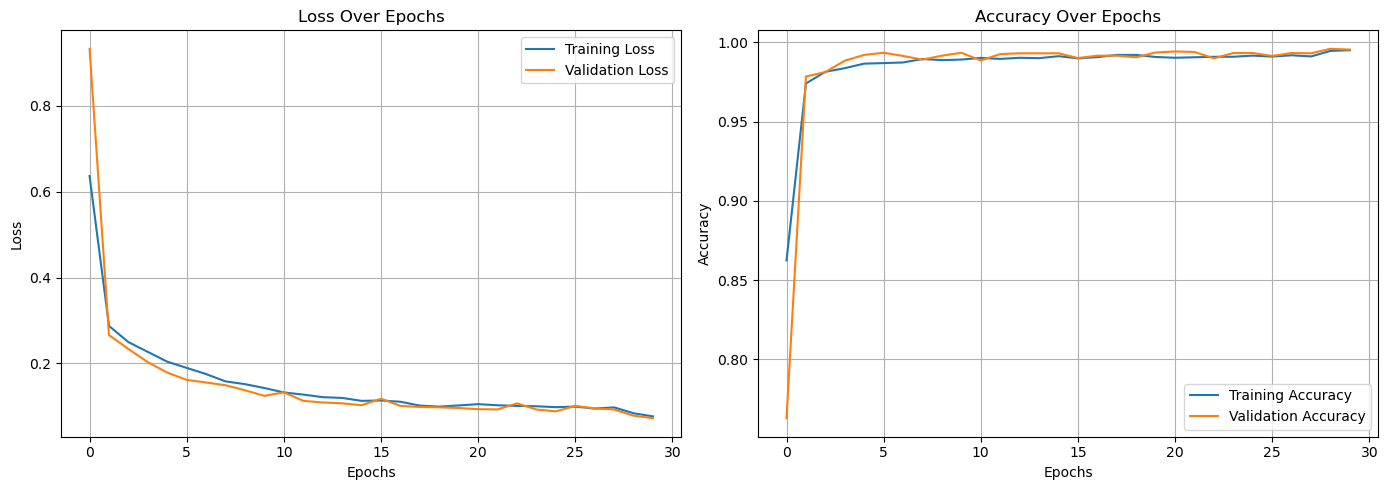

In [7]:
# loss graph
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# accuracy graph
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [8]:
# evaluate the model with test set
test_loss, test_acc = enhanced_model.evaluate(test_generator, verbose=2)
print(f"\nTest Accuracy: {test_acc:.4f}")

40/40 - 2s - 56ms/step - accuracy: 0.9965 - loss: 0.0675

Test Accuracy: 0.9965


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


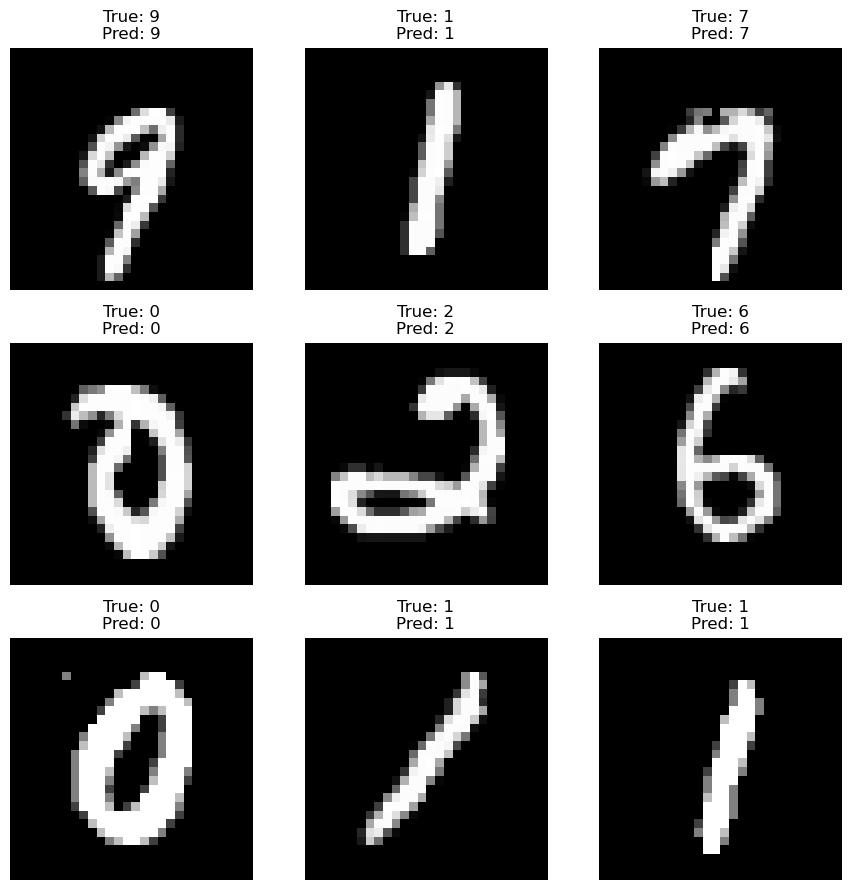

In [9]:
# helper function to test the model on multiple images
def test_multiple_images(model, x_test, y_test, num_images=9):
    grid_size = int(np.ceil(np.sqrt(num_images)))
    random_indices = random.sample(range(x_test.shape[0]), num_images)
    selected_images = x_test[random_indices]
    selected_labels = y_test[random_indices]
    predictions = model.predict(selected_images)
    pred_prob = tf.nn.softmax(predictions, axis=1).numpy()
    pred_classes = np.argmax(pred_prob, axis=1)
    plt.figure(figsize=(grid_size * 3, grid_size * 3))
    for i in range(num_images):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(np.squeeze(selected_images[i]), cmap='gray')
        plt.title(f"True: {selected_labels[i]}\nPred: {pred_classes[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

num_test_images = 9
test_multiple_images(enhanced_model, x_test, y_test, num_images=num_test_images)